In [40]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce
import re
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.cluster import KMeans
from scipy import stats
from nltk.corpus import stopwords


import SimpSOM as sps
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

In [3]:
df = pd.read_csv("../../en.openfoodfacts.org.products.tsv", delimiter='\t', encoding='utf-8')

/Users/aaronchan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df.shape

(356027, 163)

### Can we identify meaningful clusters of ingredients by clustering on the macronutrient profiles of different food products?

In [5]:
def scale(x):
    return (x - np.mean(x)) / np.std(x)

In [6]:
keep_cols = ['ingredients_text',
             'carbohydrates_100g',
             'fiber_100g',
             'sugars_100g',
             'proteins_100g', 
             'fat_100g', 
             'saturated-fat_100g']
clust_df = df[keep_cols]
clust_df = clust_df.dropna()

In [7]:
clean_ingre = lambda s: " ".join(map( lambda s1: s1.strip().replace(" ", "-") , s.lower().replace(".","").replace("(",",").replace(")",",").split(",") ) )


In [8]:
clust_df["ingredients_text"] = [clean_ingre(i) for i in clust_df["ingredients_text"]]

## Keep Only Rows With The Most Common Ingredients

Rows containing ingredients that are not in the the most common words list are dropped

In [9]:
all_words = [i for ing in clust_df['ingredients_text'] for i in ing.split()]

In [10]:
most_common_words = dict(Counter(all_words).most_common(1000))

##### keep only the food with all its ingredients are common ingredients

In [11]:
clust_df = clust_df[[all(i in most_common_words.keys() for i in i_list.split()) for i_list in clust_df['ingredients_text']]]


##### Remove outliers

In [12]:
clust_df = clust_df[(np.abs(stats.zscore(clust_df.drop(["ingredients_text"], axis = 1))) < 3).all(axis = 1)]

In [13]:
for col in keep_cols[1:]:
    clust_df[col] = scale(np.array(clust_df[col]))

## Self Organizing Map

In [15]:
Xst = clust_df.drop(["ingredients_text"], axis = 1).to_numpy()

In [16]:
np.random.seed(1000)
net = sps.somNet(20, 20, Xst)
net.train(0.01, 20000)

Periodic Boundary Conditions inactive.
The weights will be initialised randomly.
Training SOM... done!


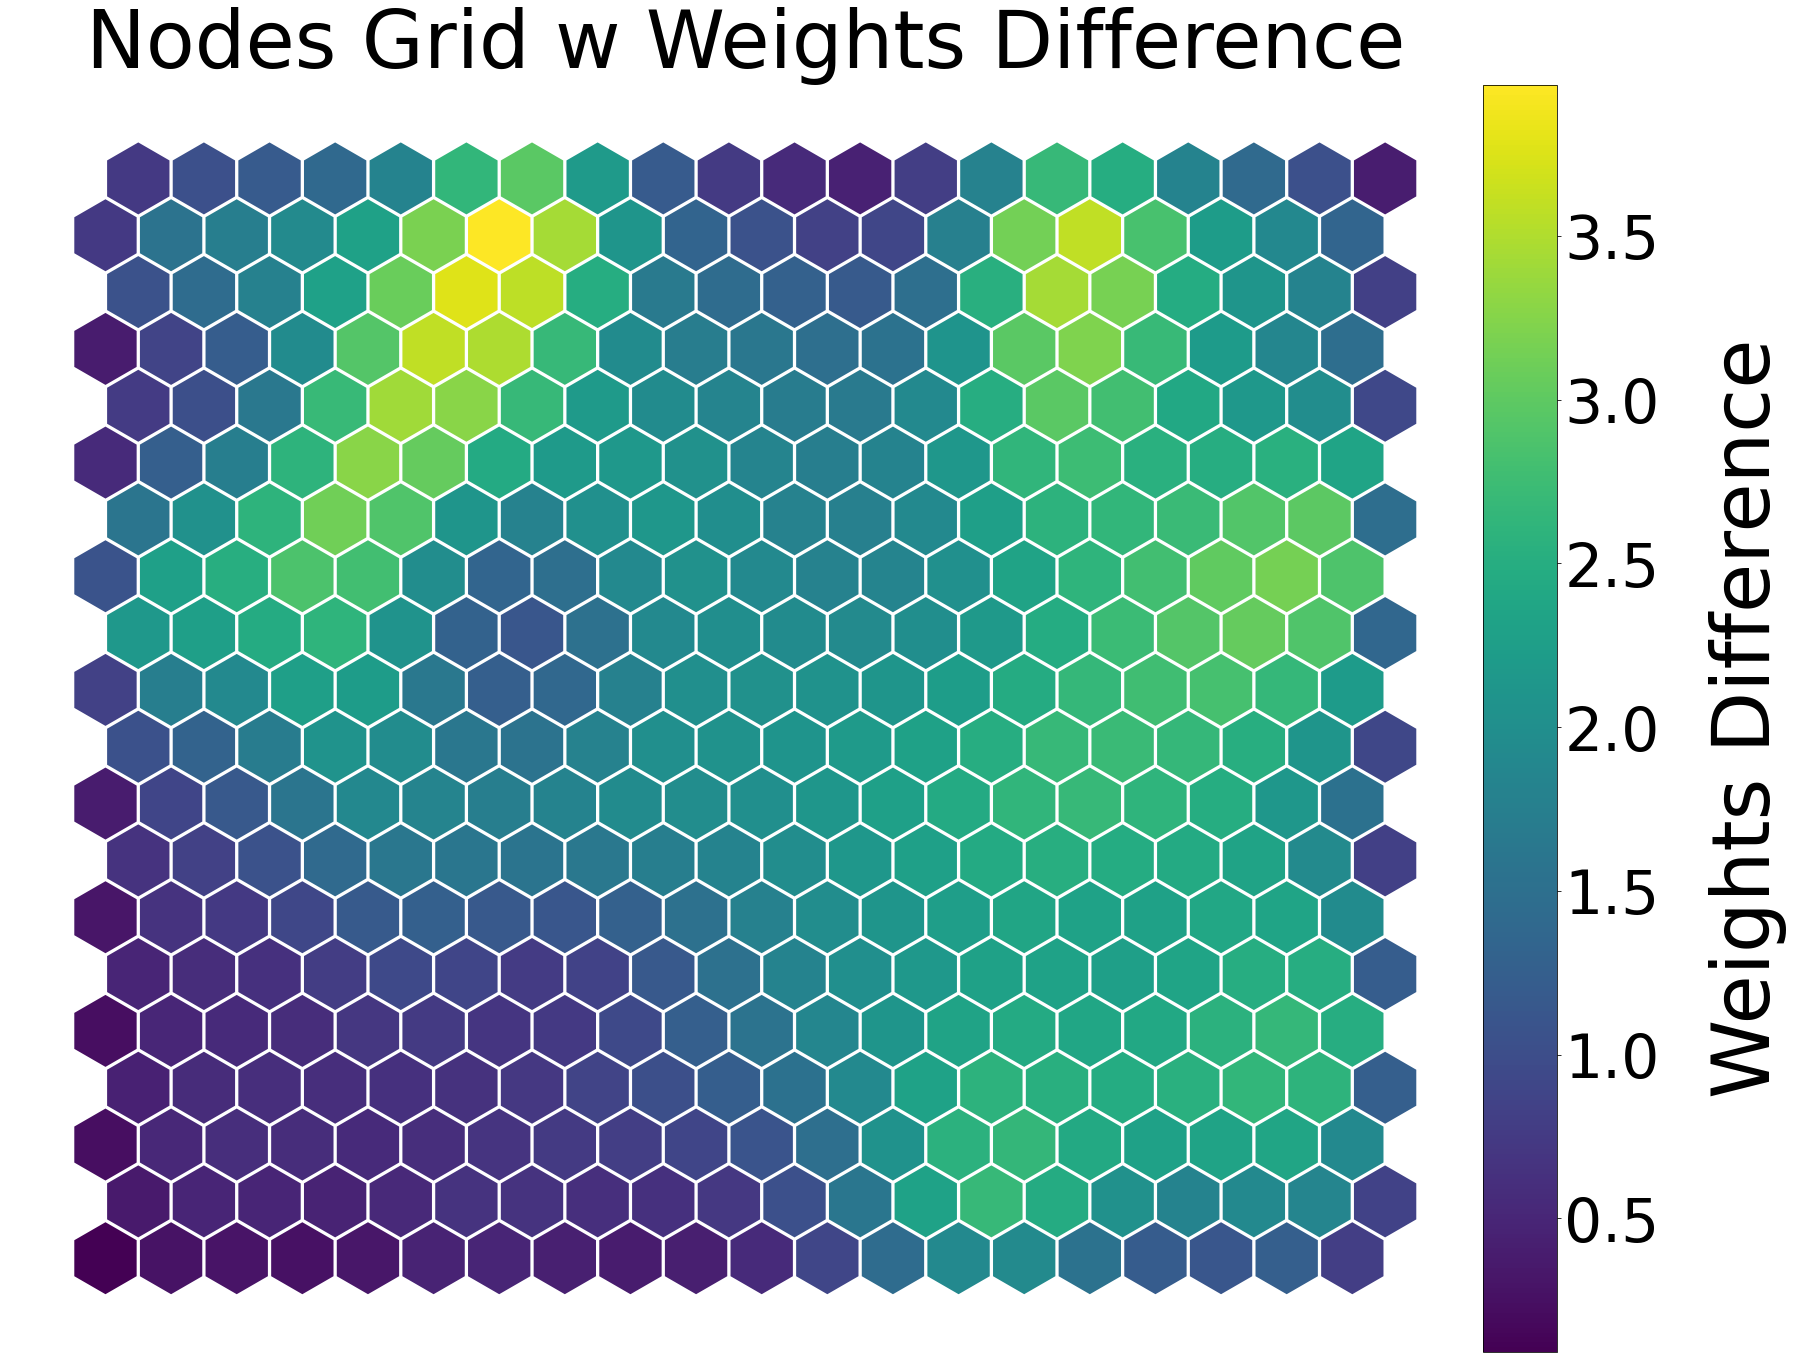

<Figure size 432x288 with 0 Axes>

In [17]:
net.diff_graph(show=True, printout=True)

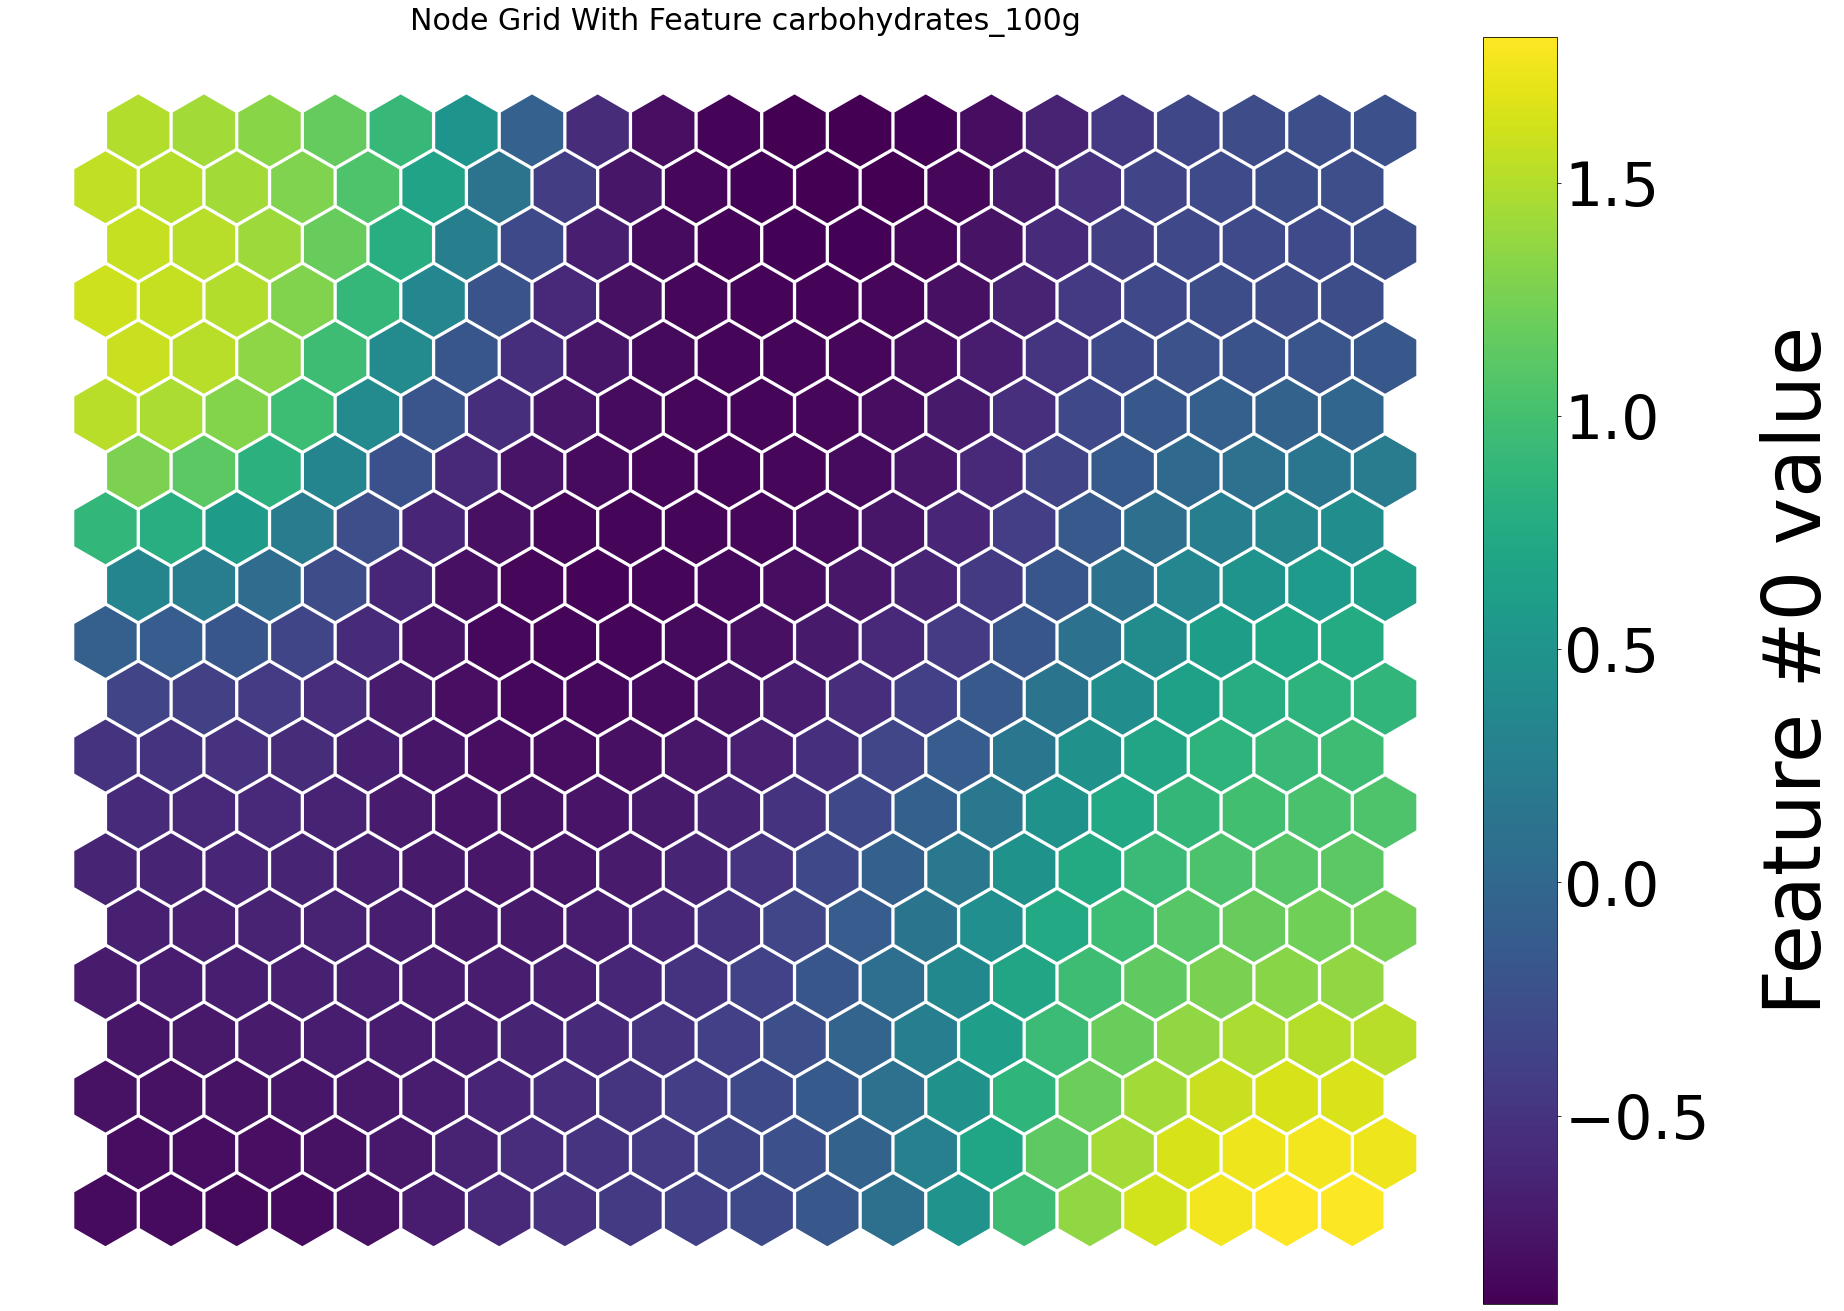

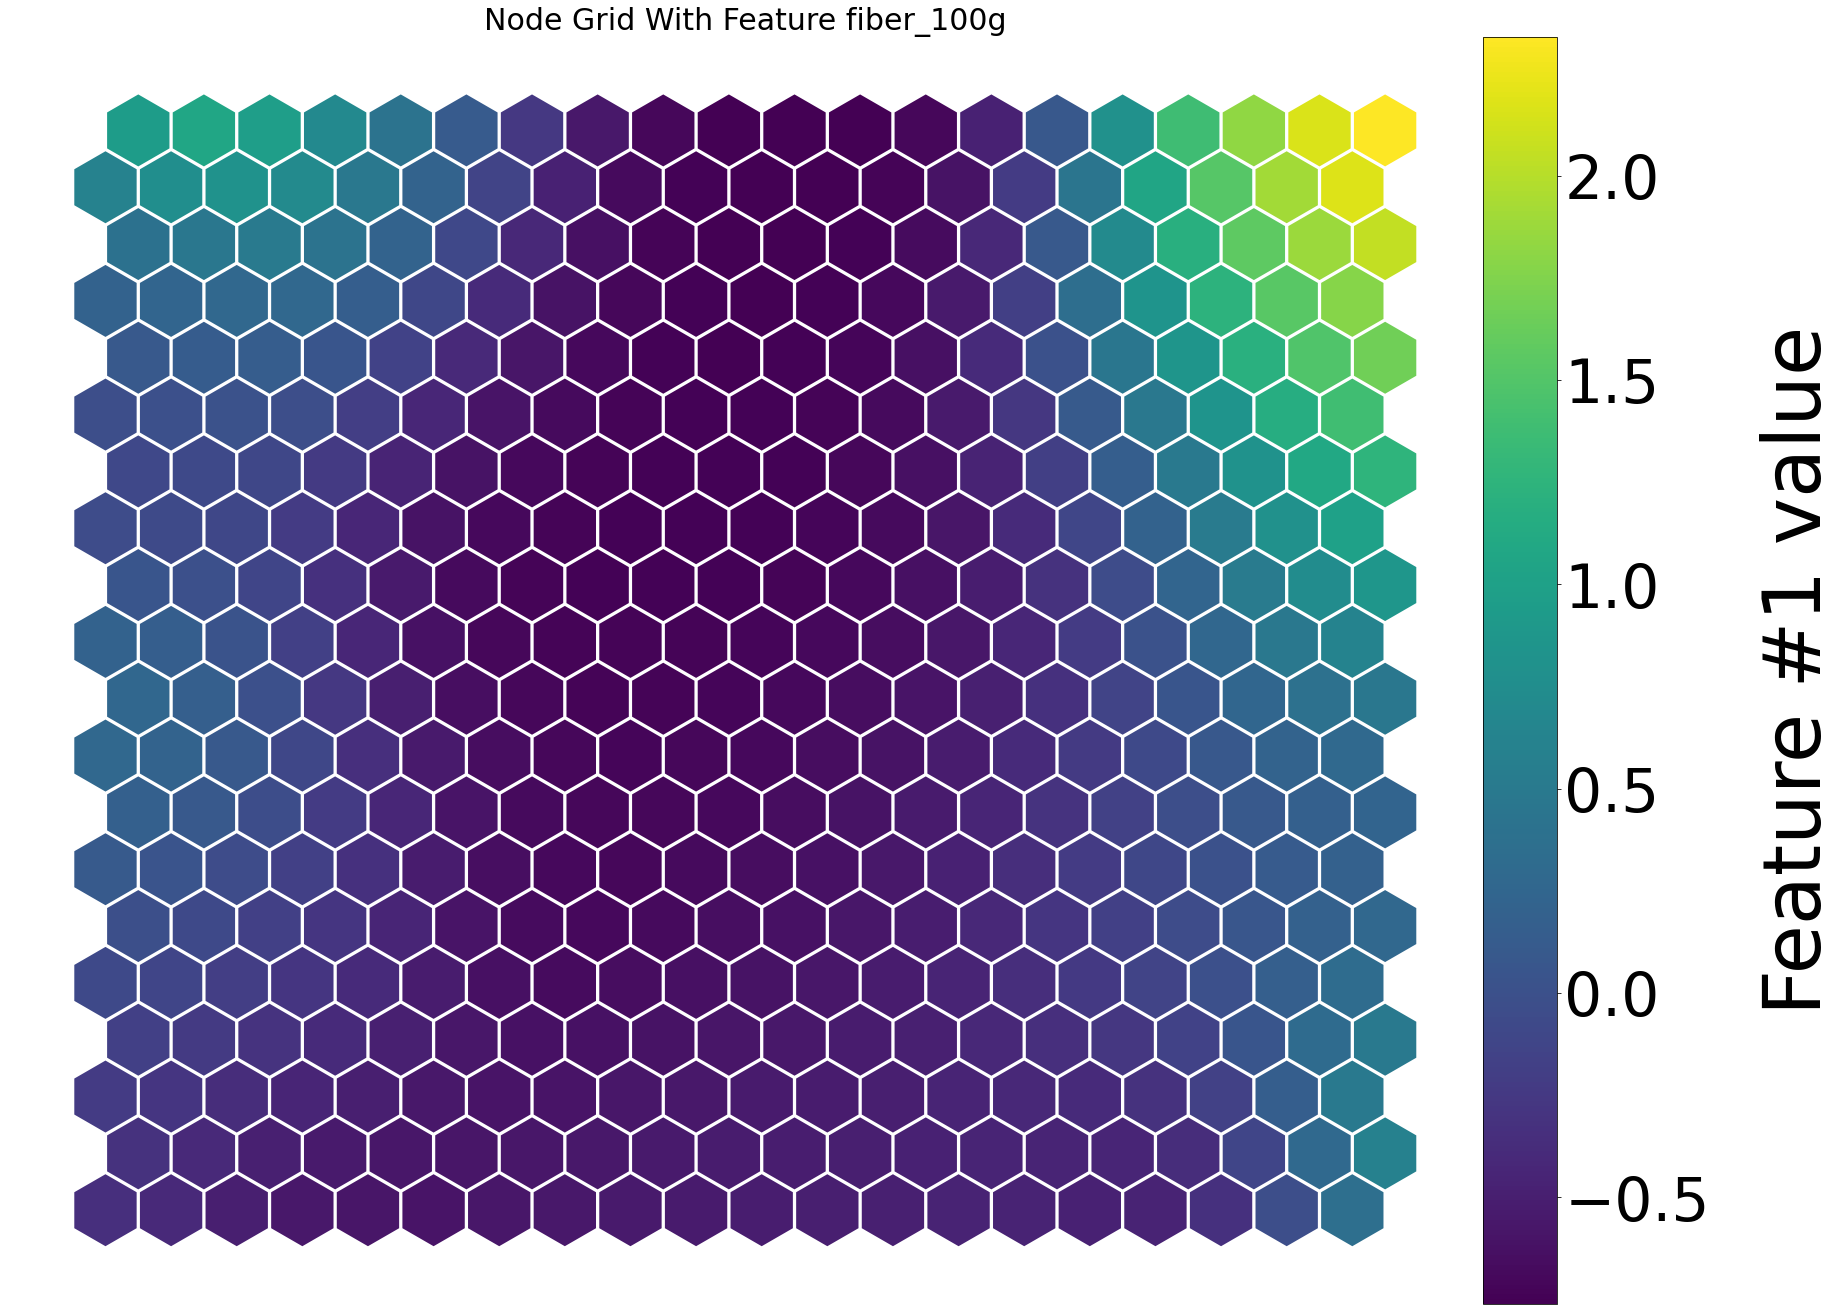

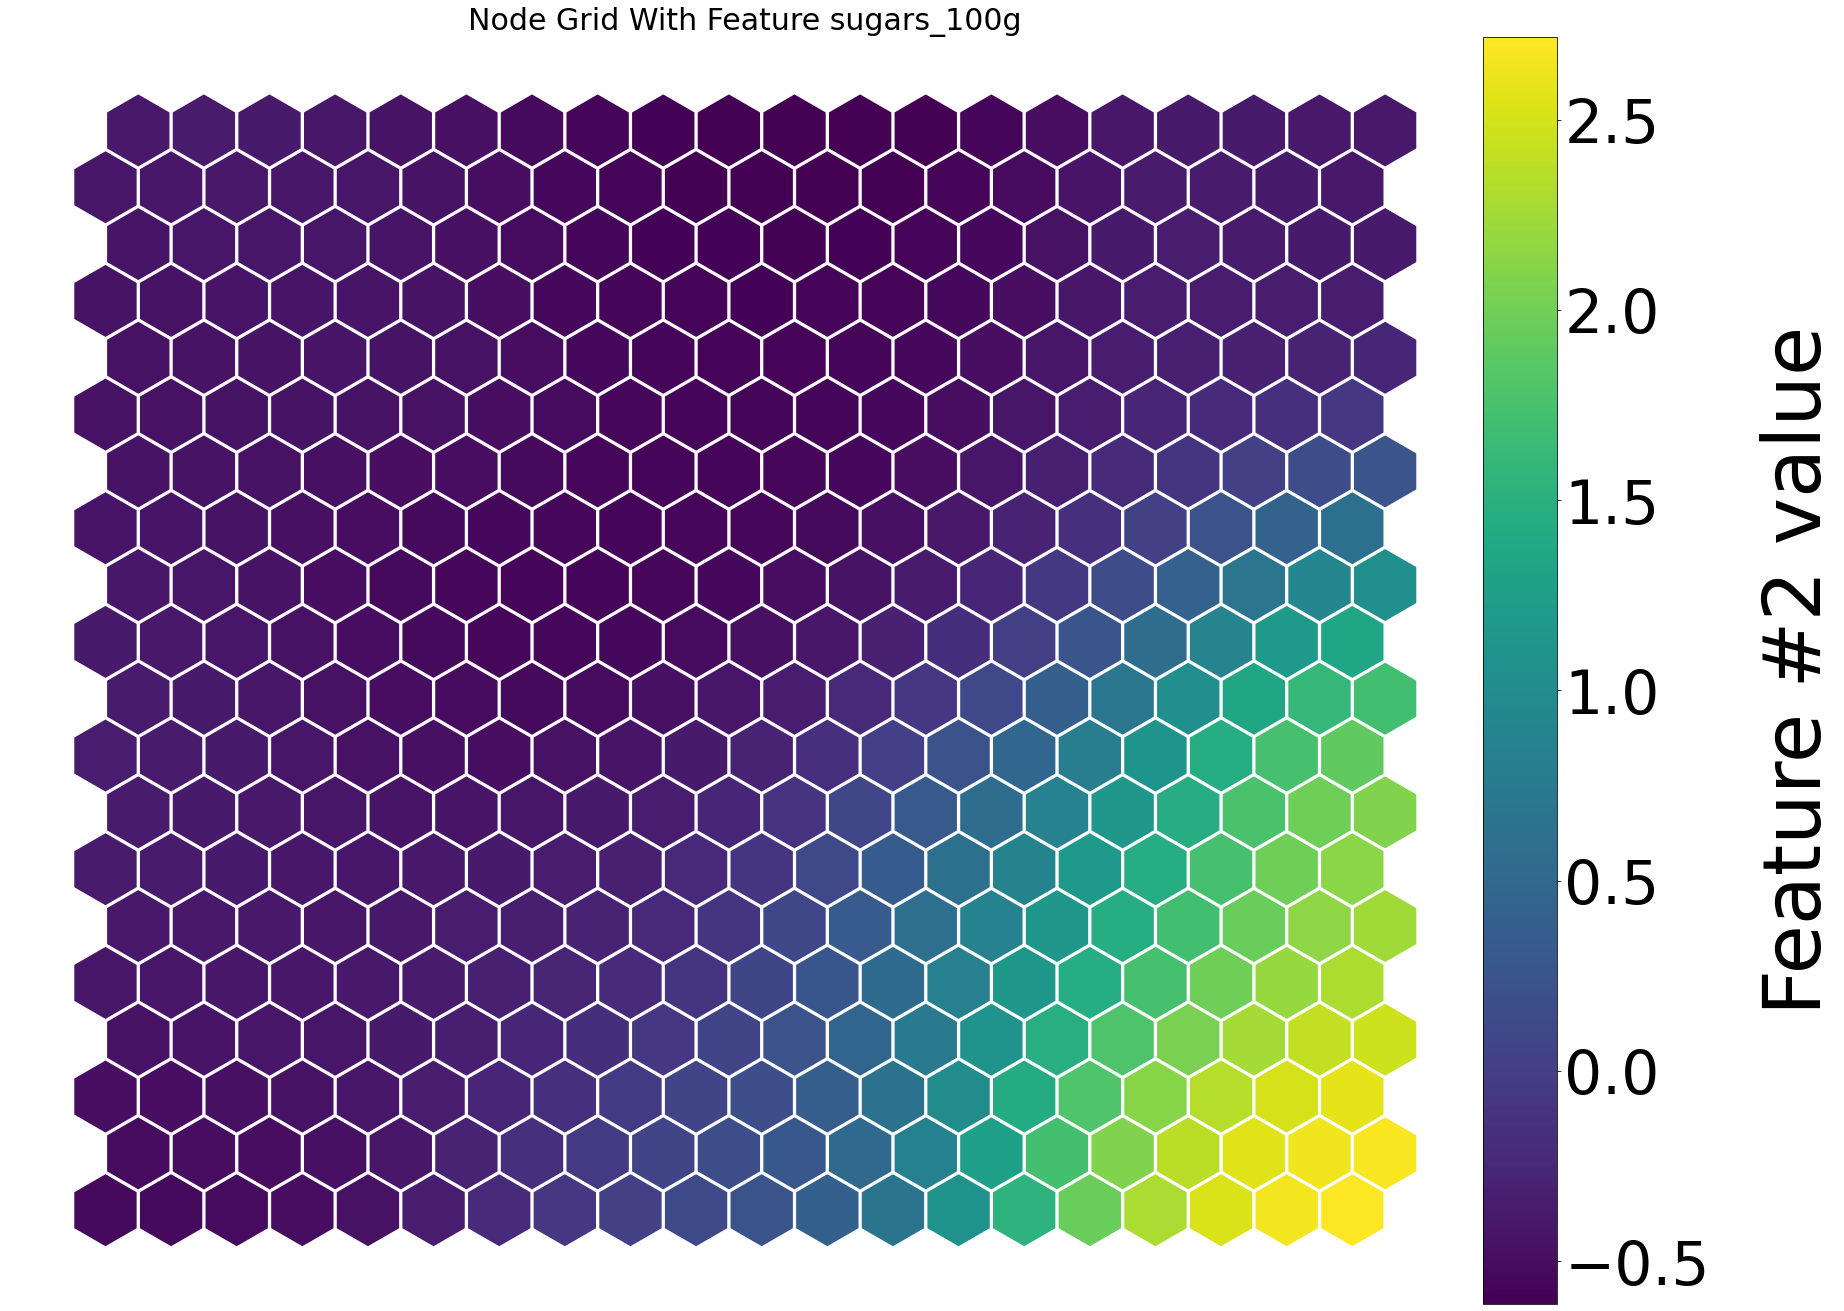

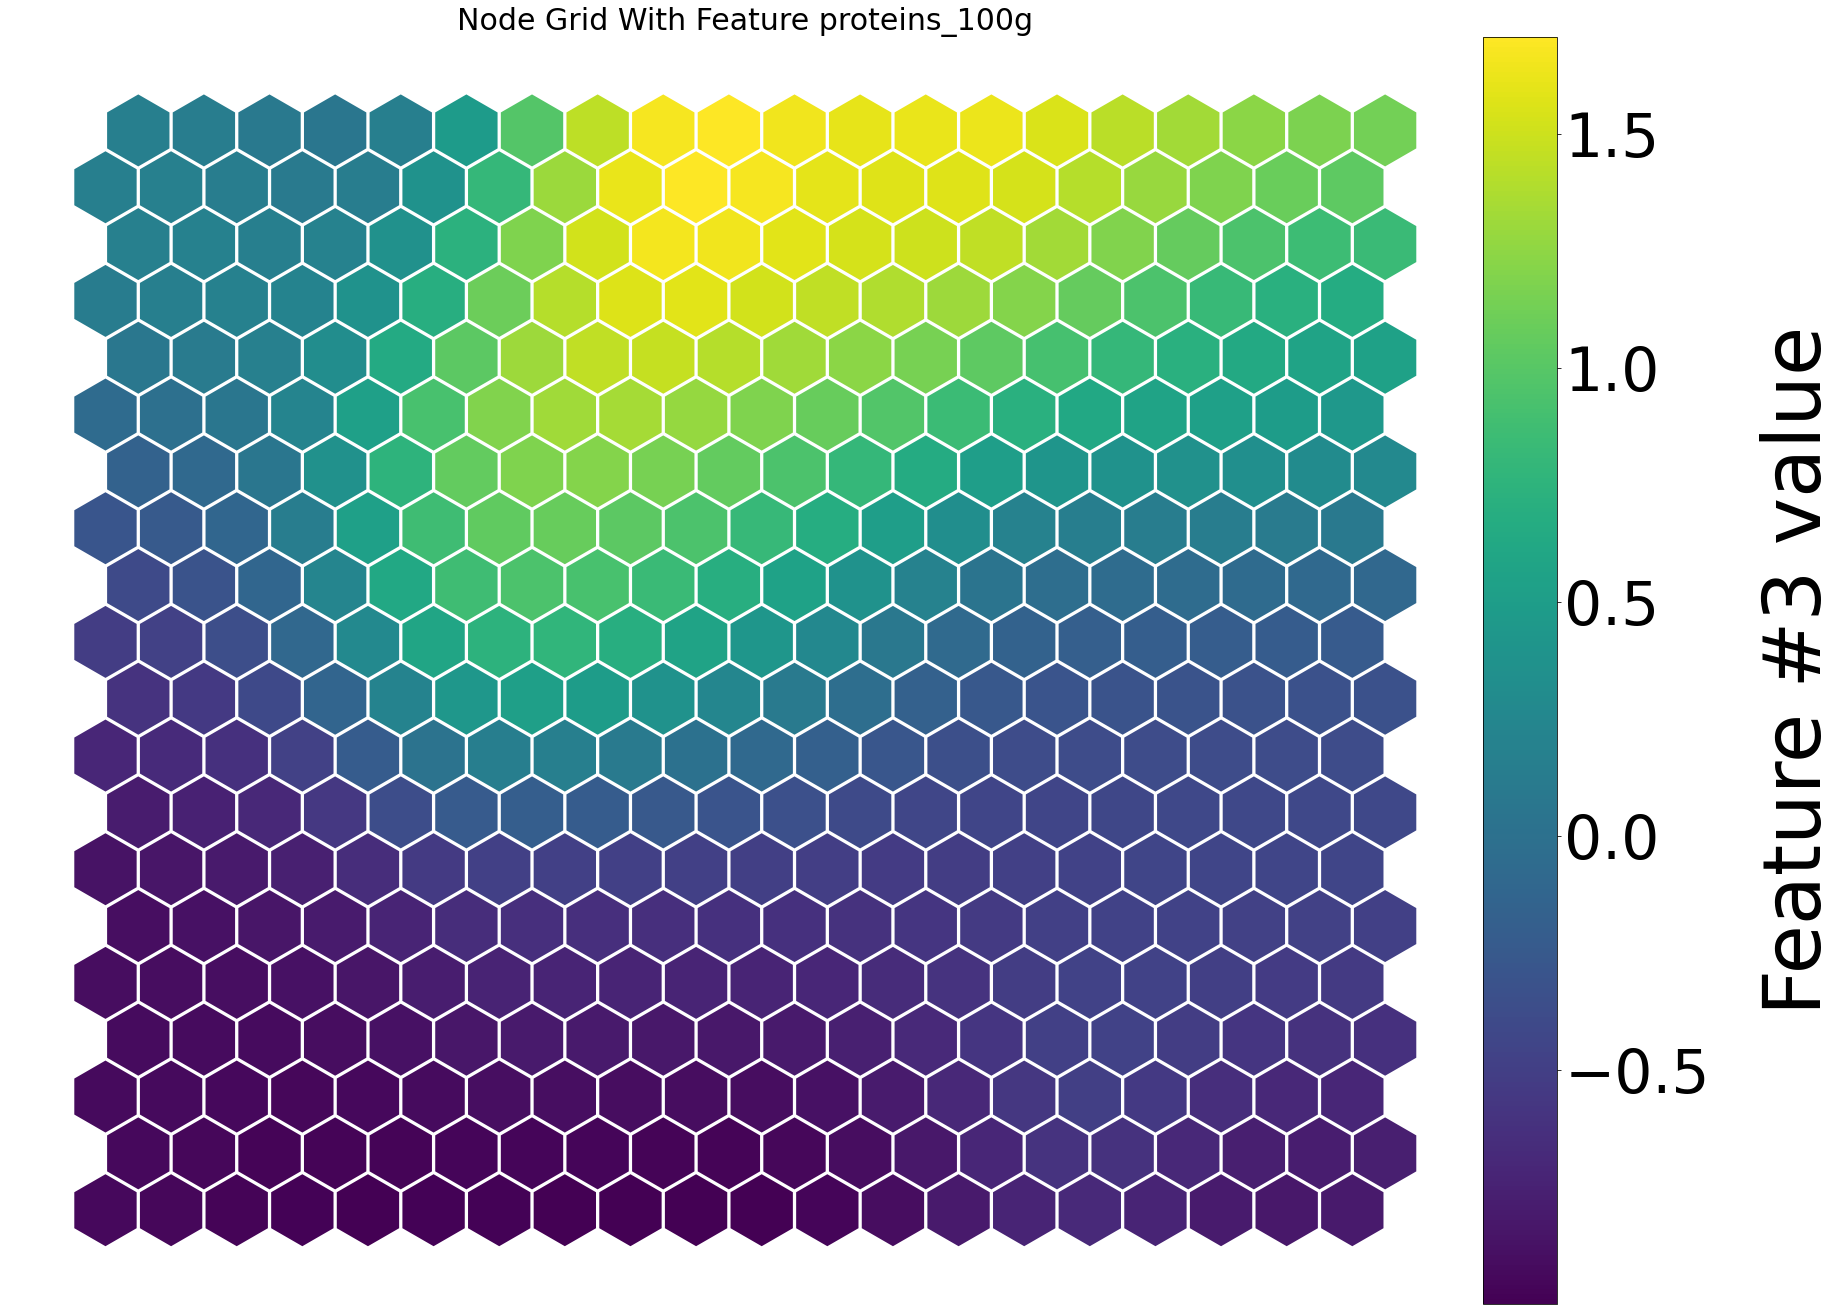

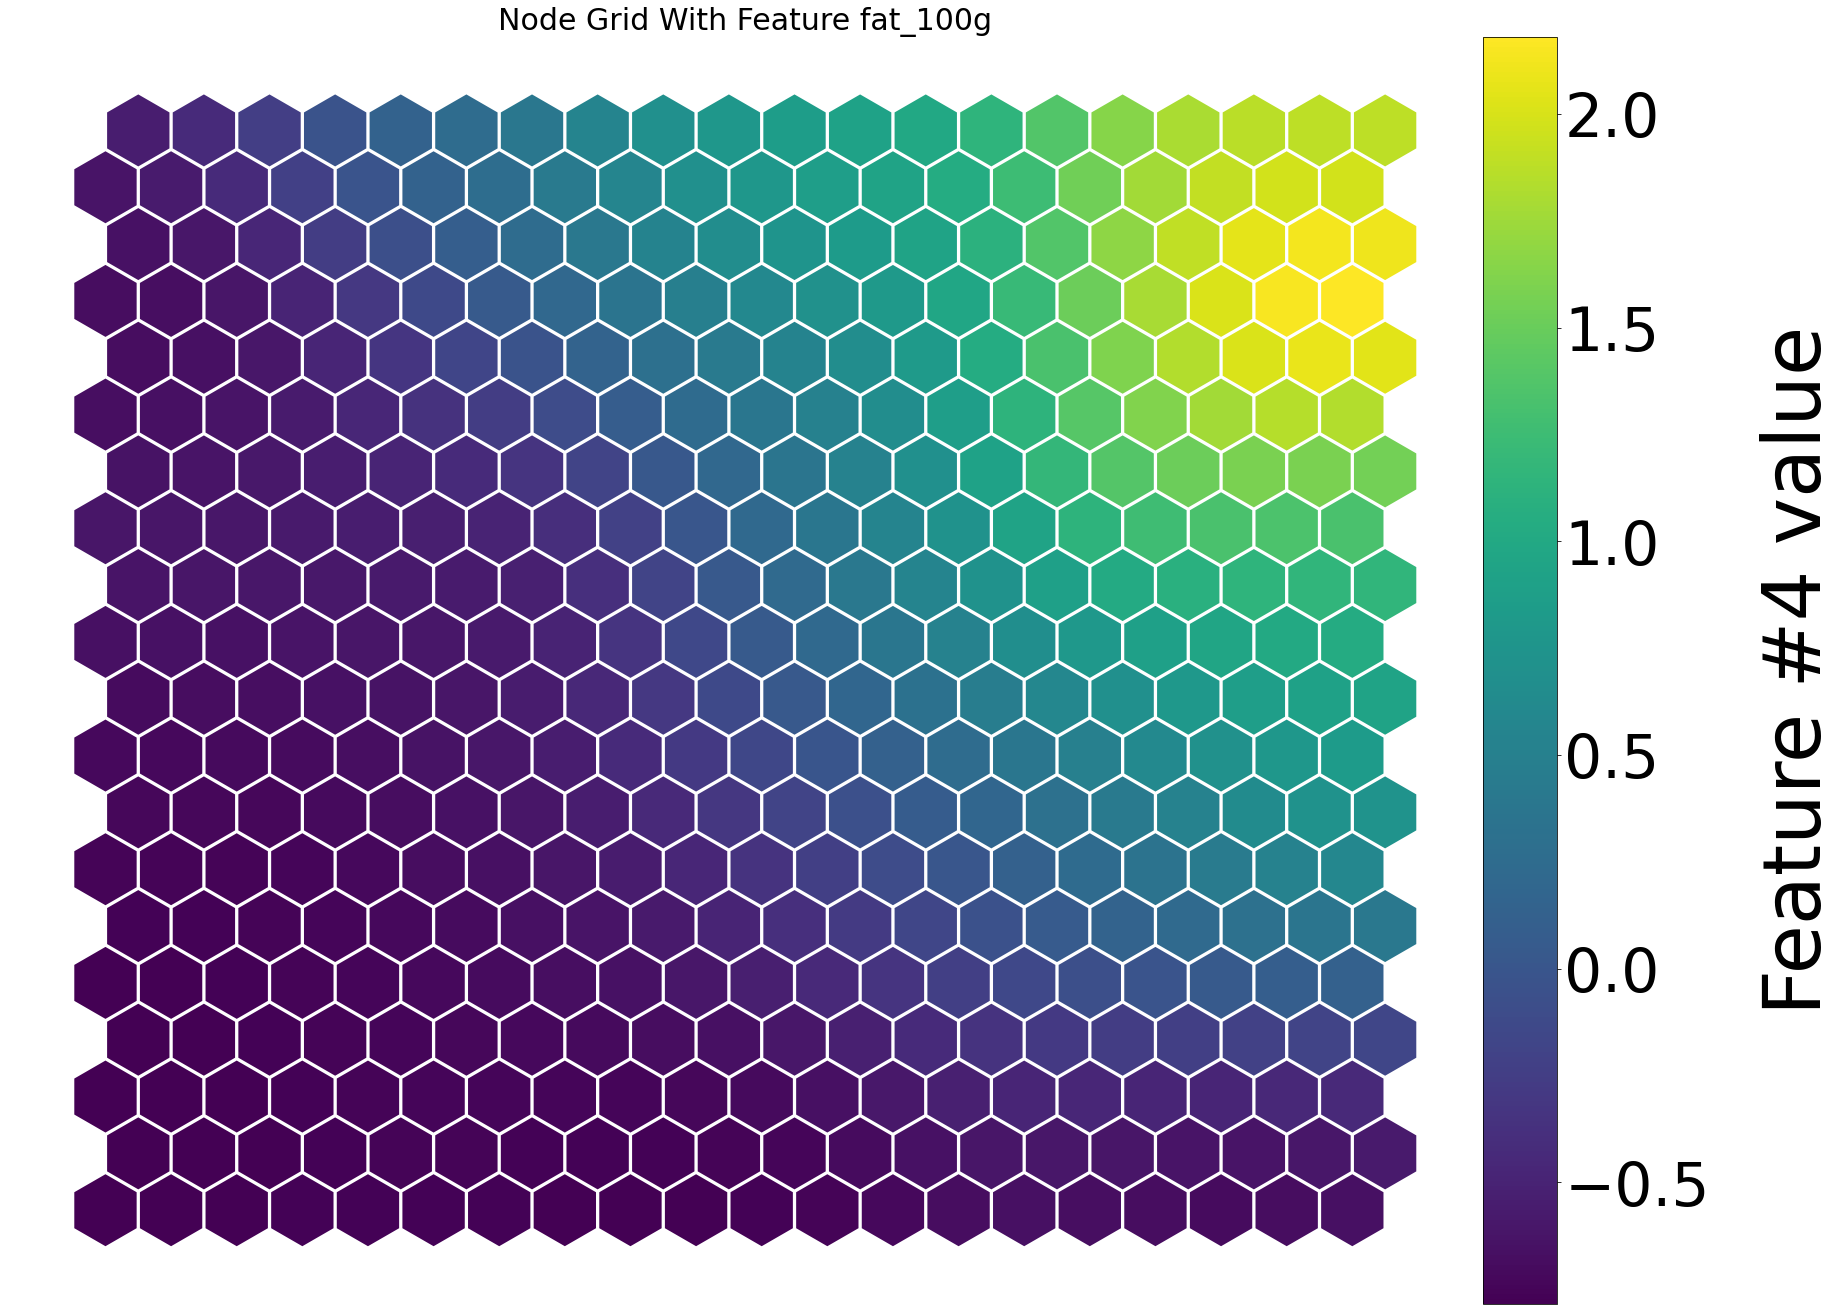

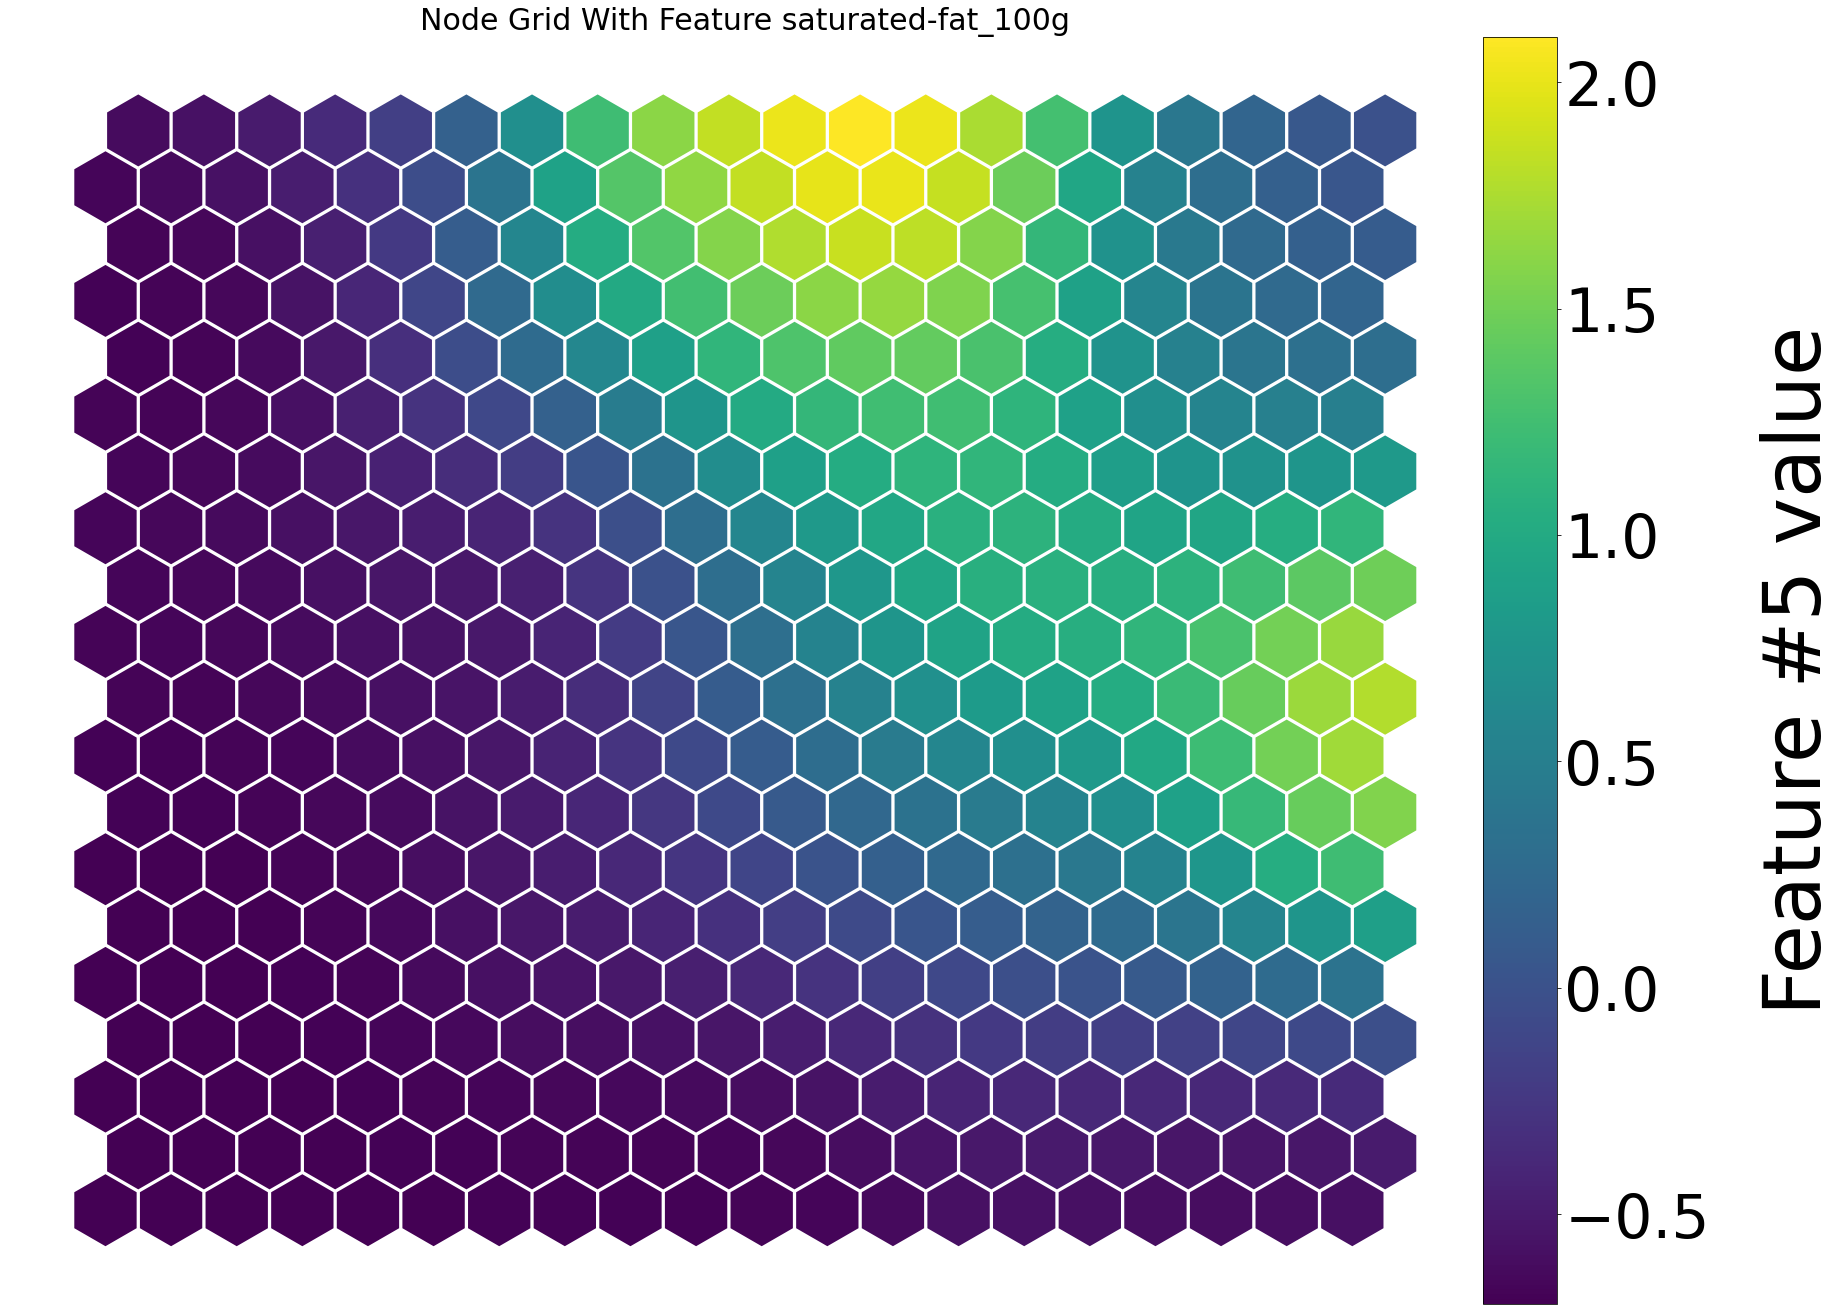

In [22]:
for i in range(0,len(clust_df.drop(["ingredients_text"], axis = 1).columns)):
    net.nodes_graph(colnum=i, printout=True)
    plt.title('Node Grid With Feature '+ clust_df.drop(["ingredients_text"], axis = 1).columns[i], size = 30)
    plt.show()

## Kmeans

In [23]:
scaledX = clust_df.iloc[:,1:]

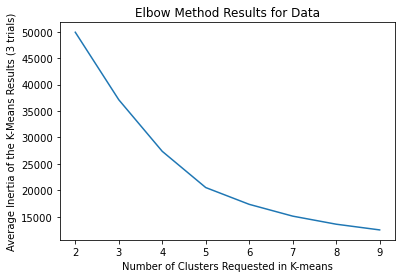

In [24]:
from sklearn.cluster import KMeans

cluster_num_list=range(2,10)
avg_inertia_list=[]
for k in cluster_num_list:
    sub_inertia_list=[]
    for i in range(0,3):
        kmeans=KMeans(n_clusters=k).fit(scaledX)
        sub_inertia_list.append(kmeans.inertia_)
    avg_inertia_list.append(np.average(sub_inertia_list))

#Plot it    
plt.plot(cluster_num_list,avg_inertia_list)
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average Inertia of the K-Means Results (3 trials)')
plt.title('Elbow Method Results for Data')
plt.savefig('kmeansElbow.png')

In [25]:
n_clust = 5

In [26]:
X = np.array(clust_df.drop(["ingredients_text"], axis = 1))
kmeans = KMeans(n_clusters = n_clust, random_state = 69).fit(X)

In [27]:
clust_df['clust'] = kmeans.labels_


In [28]:
clust_df.groupby('clust').mean()

,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g
clust,,,,,,
0,-0.619592,-0.403674,-0.293389,-0.651319,-0.678733,-0.596652
1,-0.851435,-0.747559,-0.565763,1.330765,0.704642,1.549514
2,-0.191268,1.853037,-0.327803,0.881821,1.936949,0.214688
3,1.430014,0.403714,-0.402082,0.047634,-0.459798,-0.554970
4,1.376074,0.033427,2.223347,-0.567984,-0.074301,0.233992


In [29]:
clust_df.groupby('clust').count()

,ingredients_text,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g
clust,,,,,,,
0,4970,4970,4970,4970,4970,4970,4970
1,2129,2129,2129,2129,2129,2129,2129
2,1491,1491,1491,1491,1491,1491,1491
3,1922,1922,1922,1922,1922,1922,1922
4,1765,1765,1765,1765,1765,1765,1765


#### WE USE TD-IDF TO DEFINE WORD PREVELANCE BY CLUSTER

In [30]:
rm_words = set(stopwords.words('english') + ['de', 'contains', 's', 'et', 'of', 'en', "fr",'less', 'p', 'exists', 'following', 'ok'])


In [31]:
better_words = rm_words
[better_words.add(i) for i in ['water', 'sea-salt', 'sugar', 'salt', 'sel', 'eau']]

[None, None, None, None, None, None]

In [32]:
all_words = [i for ing in clust_df['ingredients_text'] for i in ing.split()]

In [33]:
tot_word_counts = dict(Counter(all_words))

In [34]:
N = clust_df.shape[0]

In [35]:
def numDocExist(term):
    return (term in clust_word_counts0.keys()) + (term in clust_word_counts1.keys()) + \
(term in clust_word_counts2.keys()) + (term in clust_word_counts3.keys())+(term in clust_word_counts4.keys())

## Use most frequent words to define word prevelance by cluster 

In [36]:
def clust_word_prevelance(col):
    
    ### All Words For Cluster
    all_words = [i for ing in col for i in ing.split()]
    
    ### Stop Words
    reduced_words = [w for w in all_words if w not in better_words]
    
    ### Count Words
    clust_word_counts = dict(Counter(reduced_words).most_common(5))
    
#     ### TF IDF To Obtain True Cluster Prevelance 
#     for key in clust_word_counts.keys():
#         clust_word_counts[key] = clust_word_counts[key]/len(reduced_words)
    return clust_word_counts

In [37]:
clust_words = clust_df.groupby('clust')['ingredients_text'].apply(clust_word_prevelance)


               ingredients_text
citric-acid               711.0
corn-syrup                365.0
milk                      345.0
ascorbic-acid             331.0
green-beans               330.0


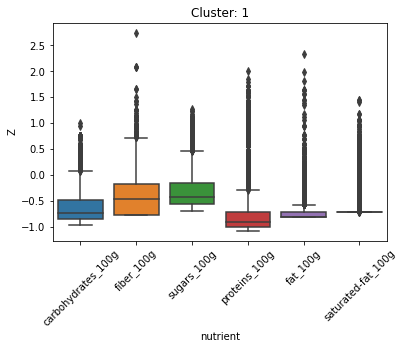

                            ingredients_text
enzymes                               1276.0
pasteurized-milk                       799.0
cheese-culture                         704.0
cheese-cultures                        342.0
pasteurized-part-skim-milk             312.0


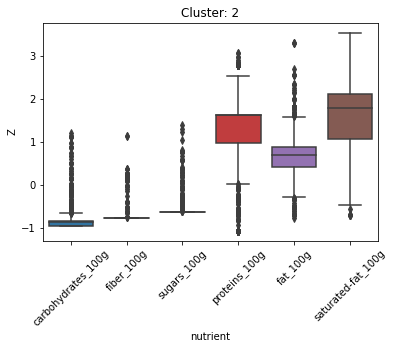

            ingredients_text
almonds                438.0
peanuts                300.0
pecans                 234.0
peanut-oil             219.0
walnuts                181.0


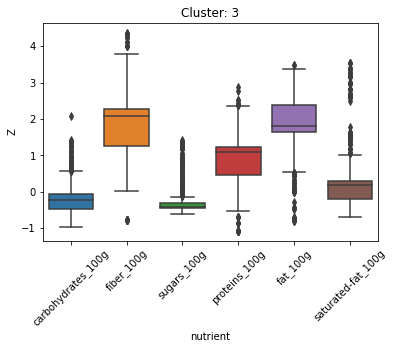

                 ingredients_text
niacin                      799.0
riboflavin                  777.0
folic-acid                  767.0
iron                        542.0
ferrous-sulfate             505.0


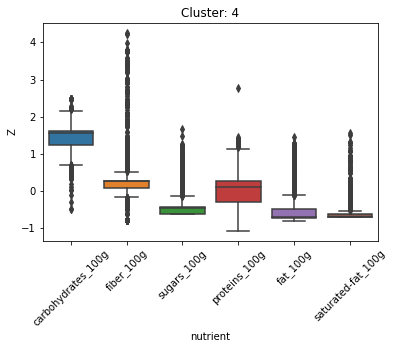

                  ingredients_text
corn-syrup                   545.0
soy-lecithin                 415.0
cocoa-butter                 384.0
citric-acid                  273.0
chocolate-liquor             259.0


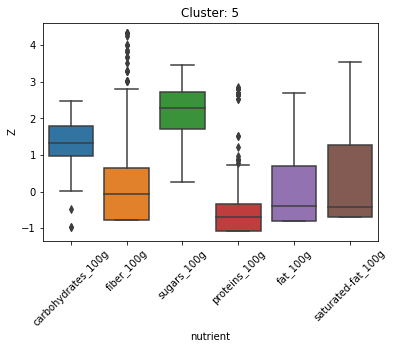

In [38]:
for c in range(n_clust):
    print(pd.DataFrame(clust_words[c]).dropna().sort_values('ingredients_text', ascending = False).iloc[:5, ])
    
    temp_df = clust_df[clust_df.clust == c]
    plot_df = pd.DataFrame(temp_df.drop(['clust', 'ingredients_text'], axis = 1).stack()).reset_index()
    plot_df.columns = ['unused', 'nutrient', 'val']
    sns.boxplot(x = 'nutrient', y = 'val', data = plot_df)
    plt.title("Cluster: " + str(c + 1))
    plt.ylabel("Z")
    plt.xticks(rotation = 45)
    plt.show()

## Hierarchical

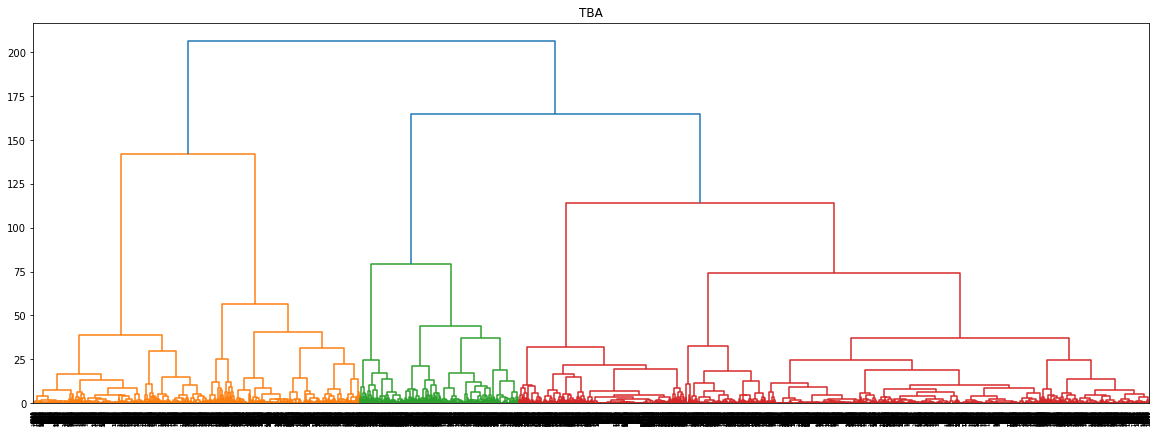

In [89]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(20, 7))
plt.title("TBA")
plt.xticks(rotation='vertical')


dend = shc.dendrogram(shc.linkage(clust_df.drop(["ingredients_text", "clust"], axis = 1), method='ward'))

In [41]:
agc = AgglomerativeClustering(n_clusters=5, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='ward')

clust_df['hierarchical5'] = agc.fit_predict(clust_df.drop(["ingredients_text", "clust"], axis = 1))

In [42]:
clust_words2 = clust_df.groupby('hierarchical5')['ingredients_text'].apply(clust_word_prevelance)


                  ingredients_text
corn-syrup                   525.0
soy-lecithin                 414.0
cocoa-butter                 408.0
citric-acid                  272.0
chocolate-liquor             266.0


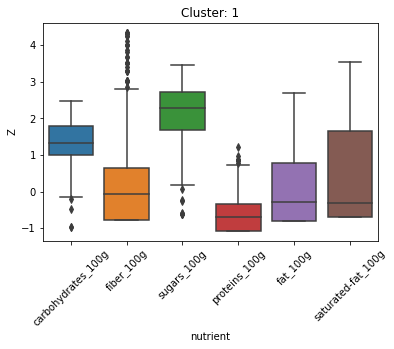

            ingredients_text
almonds                432.0
peanuts                302.0
pecans                 235.0
peanut-oil             223.0
walnuts                181.0


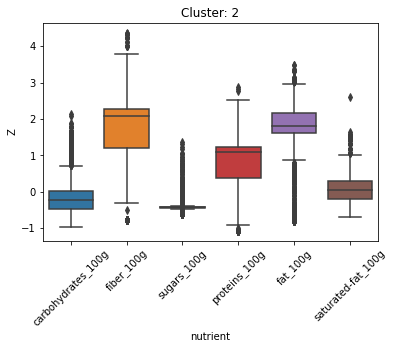

             ingredients_text
citric-acid             712.0
corn-syrup              376.0
milk                    356.0
vitamin-d3              335.0
green-beans             330.0


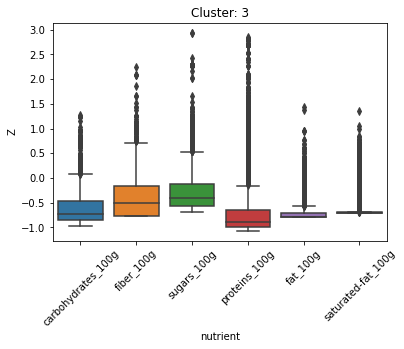

                            ingredients_text
enzymes                               1258.0
pasteurized-milk                       797.0
cheese-culture                         697.0
cheese-cultures                        330.0
pasteurized-part-skim-milk             296.0


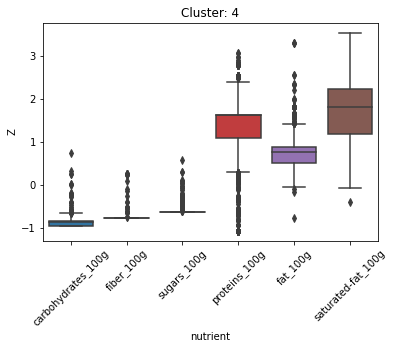

                 ingredients_text
niacin                      840.0
folic-acid                  818.0
riboflavin                  808.0
iron                        540.0
ferrous-sulfate             499.0


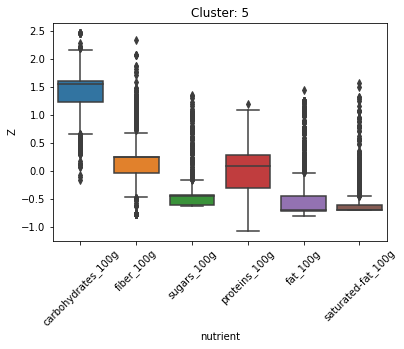

In [43]:
for c in range(5):
    print(pd.DataFrame(clust_words2[c]).dropna().sort_values('ingredients_text', ascending = False).iloc[:5, ])
    
    temp_df = clust_df[clust_df.hierarchical5 == c]
    plot_df = pd.DataFrame(temp_df.drop(['hierarchical5', 'ingredients_text', "clust"], axis = 1).stack()).reset_index()
    plot_df.columns = ['unused', 'nutrient', 'val']
    sns.boxplot(x = 'nutrient', y = 'val', data = plot_df)
    plt.title("Cluster: " + str(c + 1))
    plt.ylabel("Z")
    plt.xticks(rotation = 45)
    plt.show()

#### Looking at the carbonhydrate map, it suggests there exists two groups of observations with high carbonhydrate. One of them is highly proportionally correlated to sugar(c5 in kmeans) (c1 in hclust), while the other group is more correlated with fiber and protein.(c1 in kmeans) (c5 in hclust)

#### Looking at the fiber, protein, fat, saturated fat map, they suggests that fiber, protein, fat and saturated fat are somewhat proportionally correlated.  (c3, c4 in kmeans) (c4, c2 in hclust)


In [51]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	../.DS_Store
	.DS_Store
	.ipynb_checkpoints/Project-Copy1-checkpoint.ipynb
	0.png
	1.png
	2.png
	3.png
	4.png
	5.png
	Project-Copy1.ipynb
	SOMFiberProteinsFat.png
	SOMSFatCabohydrateSugars.png
	Screen Shot 2021-05-06 at 3.47.36 PM.png
	Screen Shot 2021-05-06 at 3.47.49 PM.png
	Screen Shot 2021-05-06 at 3.49.12 PM.png
	Screen Shot 2021-05-06 at 3.49.39 PM.png
	Screen Shot 2021-05-06 at 3.49.58 PM.png
	hclustFig.png
	hclustk5.png
	kmeans0.png
	kmeans1.png
	kmeans2.png
	kmeans3.png
	kmeans4.png
	kmeansElbow.png
	kmeansk5.png
	nodesDifference.png
	nodesFeature_0.png
	nodesFeature_1.png
	nodesFeature_2.png
	nodesFeature_3.png
	nodesFeature_4.png
	nodesFeature_5.png

nothing added to commit but untracked files present (use "git add" to track)
